<a href="https://colab.research.google.com/github/joaochenriques/WaveEnergyStatistics/blob/main/WaveEnergyStatistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mpl
import sys, pathlib
import itertools
from scipy import optimize
from sortedcontainers import SortedDict

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)

import pathlib, subprocess

def cmdcall( cmd ):
    output = subprocess.getoutput( cmd )
    print(output)

if not pathlib.Path("mpl_utils.py").exists():
  cmdcall( 'curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py' )

import mpl_utils as mut
mut.config_plots()

markers = ( 'o', '^', 's', 'v', 'H', 'X', 'P' )

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  3921  100  3921    0     0  26673      0 --:--:-- --:--:-- --:--:-- 26673


In [87]:
cmdcall( 'pip install unidecode' )
from unidecode import unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 5.3 MB/s eta 0:00:00


In [2]:
cmdcall( 'pip install dataclassy' )
from dataclassy import dataclass

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
cmdcall( 'pip install iso3166' )
from iso3166 import countries

country_lst = []
for c in countries:
    country_lst.append( c.name )

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
def left_align( df ):
    left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
    left_aligned_df = left_aligned_df.set_table_styles(
        [dict(selector='th', props=[('text-align', 'left')])]
    )
    return left_aligned_df

# Scopus advanced search query

```
TITLE-ABS-KEY-AUTH(WAVE-ENERGY) AND PUBYEAR AFT 2002 AND DOCTYPE(ar OR re) AND
(
    SRCTITLE(applied-energy) OR
    SRCTITLE(applied-ocean-research) OR
    SRCTITLE(energy) OR
    SRCTITLE(energy-conversion-and-management ) OR
    SRCTITLE(energies) OR
    SRCTITLE(ieee-transactions-on-sustainable-energy) OR
    SRCTITLE(iet-renewable-power-generation) OR
    SRCTITLE(international-journal-of-marine-energy ) OR
    SRCTITLE(international-journal-of-offshore-and-polar-engineering ) OR
    SRCTITLE(journal-of-offshore-mechanics-and-arctic-engineering) OR
    SRCTITLE(Journal-of-Ocean-Engineering-and-Marine-Energy) OR
    SRCTITLE(ocean-engineering) OR
    SRCTITLE(marine-structures) OR
    SRCTITLE(renewable-energy) OR
    SRCTITLE(renewable-sustainable-energy-reviews) 
)
```

In [140]:
filename = 'scopus_20230610.csv'
if 'google.colab' in sys.modules and not pathlib.Path( f"{filename}").exists():
    cmdcall( f'curl -O https://raw.githubusercontent.com/joaochenriques/PAS_STATS/main/{filename}' )

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 7205k  100 7205k    0     0  19.2M      0 --:--:-- --:--:-- --:--:-- 19.1M


In [141]:
df = pd.read_csv( filename )
df.keys()

Index(['Authors', 'Author full names', 'Author(s) ID', 'Title', 'Year',
       'Source title', 'Volume', 'Issue', 'Art. No.', 'Page start', 'Page end',
       'Page count', 'Cited by', 'DOI', 'Link', 'Affiliations',
       'Authors with affiliations', 'Author Keywords', 'Index Keywords',
       'Correspondence Address', 'Document Type', 'Publication Stage',
       'Open Access', 'Source', 'EID'],
      dtype='object')

In [142]:
authors_lst = df['Authors']
authors_ID_lst = df['Author(s) ID'] 
affiliations_lst = df['Affiliations']
title_lst = df['Title']
journal_lst = df['Source title']
year_lst = df['Year']
citations_lst = df['Cited by']
DOI_lst = df['DOI']
stage_lst = df['Publication Stage'] 

replacements_dic = {   
    'Ireland (formerly at the University of Plymouth)': 'Ireland',
    'Univ. Paris6': 'France',
    'Chinese Academy of Sciences': 'China',
    'Instituto Superior Tx000E9': 'Portugal'
}

# Countries ordered by percentage of the authors's country

In [143]:
countries_frac_dic = {}
total_valid_papers = 0

for n, ( affiliations, stage ) in enumerate( zip( affiliations_lst, stage_lst ) ):
    if stage == 'Final' and affiliations == affiliations: # detect NANs
        total_valid_papers += 1

        institutions_lst = affiliations.split( ';' )
        frac = 1.0 / len(institutions_lst)

        for institution in institutions_lst:
            country = institution.rsplit( ',', 1 )[-1].strip()

            if country in replacements_dic:
                country = replacements_dic[country]

            if not country in countries_frac_dic:
                countries_frac_dic[country] = frac
            else:
                countries_frac_dic[country] += frac

sorted_country_frac_rank = { k: v for k, v in sorted( countries_frac_dic.items(), key=lambda item: item[1], reverse=True ) }

df_country_name_lst = []
df_country_num_lst = []

col_name = f"Num papers out of {total_valid_papers}"
df_country_dic = { 
        "Country": df_country_name_lst,
        col_name: df_country_num_lst
}  

for n, ( name, num ) in enumerate( sorted_country_frac_rank.items() ):
    df_country_name_lst.append( name ) 
    df_country_num_lst.append( int(num) )

df = pd.DataFrame( df_country_dic )
df.index = df.index + 1 
df.head(20) 

,Country,Num papers out of 3597
1,China,733
2,United Kingdom,370
3,United States,362
4,Portugal,216
5,Spain,177
6,Ireland,155
7,Italy,154
8,Australia,145
9,India,142
10,Sweden,104


# Number of papers per author, citations, and highest cited paper

In [144]:
@dataclass
class data:
    name: str = None
    num_papers: int = 0
    citations: int = 0

In [145]:
papers_dic = {}

for n, ( authors, authors_ID, citations, DOI, stage ) in enumerate( zip( authors_lst, authors_ID_lst, citations_lst, DOI_lst, stage_lst ) ):
    if stage == 'Final' and authors == authors and authors_ID == authors_ID: # check NANs
        for ( author, ID ) in zip( authors.split(';'), str( authors_ID ).split(';') ):
            author = author.strip()
            ID = ID.strip()

            if ID in papers_dic:
                papers_dic[ID].num_papers += 1
                papers_dic[ID].citations += int(citations)
            else:
                papers_dic[ID] = data( author, 1, int(citations) )

In [146]:
sorted_papers_dic = { k: v for k, v in sorted( papers_dic.items(), key=lambda item: item[1].num_papers, reverse=True ) }

df_authors_name_lst = []
df_authors_num_lst = []

df_authors_dic = { 
        "Author": df_authors_name_lst,
        "Num papers": df_authors_num_lst
}  

for n, dt in enumerate( sorted_papers_dic.values() ):
    df_authors_name_lst.append( dt.name ) 
    df_authors_num_lst.append( dt.num_papers )

df = pd.DataFrame( df_authors_dic )
df.index = df.index + 1

left_align( df.head(20) )

,Author,Num papers
1,Ringwood J.V.,92
2,Iglesias G.,79
3,Guedes Soares C.,65
4,Gato L.M.C.,63
5,Henriques J.C.C.,62
6,Falcão A.F.O.,56
7,Ning D.,47
8,Greaves D.,45
9,Leijon M.,45
10,Wang Z.L.,42


In [147]:
sorted_citations_dic = { k: v for k, v in sorted( papers_dic.items(), key=lambda item: item[1].citations, reverse=True ) }

df_citations_name_lst = []
df_citations_num_lst = []

df_citations_dic = { 
        "Author": df_citations_name_lst,
        "Citations": df_citations_num_lst
}  

for n, dt in enumerate( sorted_citations_dic.values() ):
    df_citations_name_lst.append( dt.name ) 
    df_citations_num_lst.append( dt.citations )

df = pd.DataFrame( df_citations_dic )
df.index = df.index + 1 
left_align( df.head(10) )

,Author,Citations
1,Falcão A.F.O.,4992
2,Iglesias G.,4917
3,Wang Z.L.,4698
4,Ringwood J.V.,3161
5,Guedes Soares C.,2666
6,Babarit A.,2529
7,Henriques J.C.C.,2385
8,Moan T.,2337
9,Carballo R.,2022
10,Jiang T.,1977


In [148]:
@dataclass
class paper_rank:
    authors: str = None
    title: str = None
    journal: str =None
    year: int = 0
    DOI: str = None
    citations: int = 0

In [149]:
papers_rank_dic = {}

for n, ( authors, title, journal, year, DOI, citations, stage ) in enumerate( zip( authors_lst, title_lst, journal_lst, year_lst, DOI_lst, citations_lst, stage_lst ) ):
    if stage == 'Final' and authors == authors: # check NANs
        papers_rank_dic[DOI] = paper_rank( authors, title, journal, year, DOI, int( citations ) )

In [150]:
sorted_papers_rank_dic = { k: v for k, v in sorted( papers_rank_dic.items(), key=lambda item: item[1].citations, reverse=True ) }

df_authors_name_lst = []
df_title_lst = []
df_journal_lst = []
df_year_lst = []
df_DOI_lst = []
df_citations_lst = []

df_papers_rank_dic = { 
        "Authors": df_authors_name_lst,
        "Title": df_title_lst,
        "Journal": df_journal_lst,
        "Year": df_year_lst,
        # "DOI": df_DOI_lst,
        "citations": df_citations_lst
}  

for n, dt in enumerate( sorted_papers_rank_dic.values() ):
    df_authors_name_lst.append( dt.authors ) 
    df_title_lst.append( dt.title )
    df_journal_lst.append( dt.journal )
    df_year_lst.append( dt.year )
    df_DOI_lst.append( dt.DOI )
    df_citations_lst.append( dt.citations )

df = pd.DataFrame( df_papers_rank_dic )
df.index = df.index + 1
left_align( df.head(10) )

,Authors,Title,Journal,Year,citations
1,Falcão A.F.d.O.,Wave energy utilization: A review of the technologies,Renewable and Sustainable Energy Reviews,2010,2036
2,Drew B.; Plummer A.R.; Sahinkaya M.N.,A review of wave energy converter technology,"Proceedings of the Institution of Mechanical Engineers, Part A: Journal of Power and Energy",2009,867
3,Falnes J.,A review of wave-energy extraction,Marine Structures,2007,809
4,Wang Z.L.; Jiang T.; Xu L.,Toward the blue energy dream by triboelectric nanogenerator networks,Nano Energy,2017,727
5,Falcão A.F.O.; Henriques J.C.C.,Oscillating-water-column wave energy converters and air turbines: A review,Renewable Energy,2016,594
6,Babarit A.; Hals J.; Muliawan M.J.; Kurniawan A.; Moan T.; Krokstad J.,Numerical benchmarking study of a selection of wave energy converters,Renewable Energy,2012,551
7,López I.; Andreu J.; Ceballos S.; Martínez De Alegría I.; Kortabarria I.,Review of wave energy technologies and the necessary power-equipment,Renewable and Sustainable Energy Reviews,2013,533
8,Gunn K.; Stock-Williams C.,Quantifying the global wave power resource,Renewable Energy,2012,436
9,Pérez-Collazo C.; Greaves D.; Iglesias G.,A review of combined wave and offshore wind energy,Renewable and Sustainable Energy Reviews,2015,403
10,Hussain A.; Arif S.M.; Aslam M.,Emerging renewable and sustainable energy technologies: State of the art,Renewable and Sustainable Energy Reviews,2017,335


# Papers per year

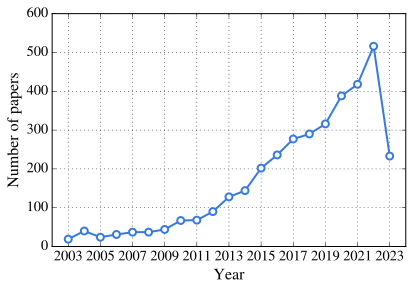

In [198]:
year_dic = {i:0 for i in range( min( year_lst ), max( year_lst )+1 ) }

for n, ( year, stage ) in enumerate( zip( year_lst, stage_lst ) ):
    if stage == 'Final' and affiliations == affiliations: # detect NANs
        year_dic[year] += 1

mpl.figure( 1, figsize=(6,4) )
mpl.plot( year_dic.keys(), year_dic.values(), 'o-', 
         linewidth=2, color='#3679e0',
         markersize=7, markerfacecolor='w', markeredgewidth=2,
         markeredgecolor='#3679e0' )
mpl.xlim( (2002, 2024) )
mpl.grid()
mpl.xlabel( 'Year' )
mpl.ylabel( 'Number of papers' )
mpl.gca().set_axisbelow(True)
mpl.gca().set_xticks( range( min( year_lst ), max( year_lst )+1, 2 ) );

# Sort by Institution -> NOT WORKING

In [153]:
institutions_dic = {}
invalid = {}

words_lst = ['Instituto Superior Tecnico', 'University', 'Sandia', 'Institute of Technology', 
             'Universite', 'Universiti',
             'Universitat', 'Universidade', 'Univ.', 'Universidad',
             'Universita', 'Politecnico', 'WavEC', 'IIT', 'Ecole', 'SINTEF']
            

for n, ( affiliations, stage ) in enumerate( zip( affiliations_lst, stage_lst ) ):
    if stage == 'Final' and affiliations == affiliations: # detect NANs

        institutions_lst = affiliations.split( ';' )

        for institution in institutions_lst:
            institution = institution.strip()
            tokens = institution.split( ',' )

            short_inst = ''
            found = False

            for token in tokens:
                token = unidecode( token.strip() )

                if not any( map( str.isdigit, token ) ):
                    if not short_inst:
                        short_inst = token                    
                    else:
                        short_inst = short_inst + ', ' + token                    

                    if any( word in token for word in words_lst ):
                        found = True

            if found:
                if short_inst in institutions_dic:
                    institutions_dic[short_inst] += 1
                else:
                    institutions_dic[short_inst] = 1  
            else:
                if institution in invalid: 
                    invalid[short_inst] += 1
                else:
                    invalid[short_inst] = 1

len( invalid ), len( institutions_dic )

(1403, 4008)

In [154]:
sorted_country_frac_rank = { k: v for k, v in sorted( institutions_dic.items(), key=lambda item: item[1], reverse=True ) }

df_country_name_lst = []
df_country_num_lst = []

col_name = f"Num papers out of {total_valid_papers}"
df_country_dic = { 
        "Country": df_country_name_lst,
        col_name: df_country_num_lst
}  

for n, ( name, num ) in enumerate( sorted_country_frac_rank.items() ):
    df_country_name_lst.append( name ) 
    df_country_num_lst.append( int(num) )

df = pd.DataFrame( df_country_dic )
df.index = df.index + 1 
df 

,Country,Num papers out of 3597
1,State Key Labora...,87
2,College of Shipb...,48
3,College of Engin...,37
4,Shandong Provinc...,35
5,Sandia National ...,32
...,...,...
4004,"LEICI, Depto. de...",1
4005,Wave Energy Rese...,1
4006,Mech./Manufactur...,1
4007,Department of Me...,1
